In [41]:
import numpy as np
from timeit import default_timer as timer

def value_iteration(env, theta=0.0001, gamma=1.0):
    """
    Value Iteration Algorithm.
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment.
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than delta for all states.
        gamma: Gamma discount factor.
    Returns:
        A tuple (policy, V, iterations) of the optimal policy, the optimal value function, and iterations.
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + gamma * V[next_state])
        return A

    V = np.zeros(env.nS)
    delta_list = []
    time_list = []
    cum_time_list = []
    total_value_list = []
    iterations = 0
    while True:
        start_time = timer()
        iterations += 1
        delta = 0
        for state in range(env.nS):
            A = one_step_lookahead(state, V)  
            best_act_value = np.max(A)
            delta = max(delta, np.abs(best_act_value - V[state]))
            V[state] = best_act_value  # update value to best action value
            
        end_time = timer()
        run_time = end_time - start_time
        delta_list.append(delta)
        time_list.append(run_time)
        cum_time_list.append(sum(time_list))
        total_value_list.append(np.sum(V))
        
        if delta < theta:  # if delta improvement is less than threshold
            break
            
    policy = np.zeros([env.nS, env.nA])
    for state in range(env.nS): 
        A = one_step_lookahead(state, V)
        best_action = np.argmax(A)
        policy[state][best_action] = 1.0
        
    return policy, V, iterations, delta_list, time_list, cum_time_list, total_value_list

def policy_evaluation(policy, env, theta=0.0001, gamma=1.0, max_steps=3000):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment.
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        gamma: Gamma discount factor.
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    steps = 0
    while steps < max_steps:
        delta = 0
        steps += 1
        for state in range(env.nS):
            val = 0  # initiate value as 0
            for action, act_prob in enumerate(policy[state]):  # for all actions/action probabilities
                for prob, next_state, reward, done in env.P[state][action]:
                    val += act_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(val - V[state]))
            V[state] = val
        if delta < theta:  # if delta improvement is less than threshold
            break
    return np.array(V)


def policy_iteration(env, policy_eval_function=policy_evaluation, gamma=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    Args:
        env: The OpenAI envrionment.
        policy_eval_function: Policy Evaluation function that takes 3 arguments:
            policy, env, gamma.
        discount_factor: gamma discount factor.
    Returns:
        A tuple (policy, V).
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + gamma * V[next_state])
        return A
    
    policy = np.ones([env.nS, env.nA]) / env.nA # Start with a random policy
    time_list = []
    cum_time_list = []
    total_value_list = []
    iterations = 0
    while True:
        start_time = timer()
        iterations += 1
        curr_pol_value = policy_eval_function(policy, env, gamma)  # eval current policy
        policy_stable = True  # Check if policy did improve
        for state in range(env.nS): 
            chosen_act = np.argmax(policy[state])  # best action base on current policy
            act_values = one_step_lookahead(state, curr_pol_value)
            best_act = np.argmax(act_values)  # find best action
            best_act_value = np.max(act_values)
            if chosen_act != best_act:
                policy_stable = False  # Greedily find best action
            policy[state] = np.eye(env.nA)[best_act]  # update
            
        end_time = timer()
        run_time = end_time - start_time
        time_list.append(run_time)
        cum_time_list.append(sum(time_list))
        total_value_list.append(np.sum(curr_pol_value))
        
        if policy_stable:
            return policy, curr_pol_value, iterations, time_list, cum_time_list, total_value_list

    return policy, np.zeros(env.nS), iterations, time_list, cum_time_list, total_value_list

In [42]:
import gym
import seaborn as sns
import matplotlib.pyplot as plt

env_name  = 'Taxi-v3'
env = gym.make(env_name)
gammas = [0.99, 0.95, 0.90]
gammas2 = [0.99, 0.8, 0.5]
vi_results = {}
pi_results = {}
for gamma in gammas:
    start = timer()
    policy, V, iterations, delta, time, cum_time, total_value = value_iteration(env, gamma=gamma)
    end = timer()
    print("Value Iteration: {}s in {} iters with gamma={}".format(end - start, iterations, gamma))
    vi_results[gamma] = (policy, V, iterations, delta, time, cum_time, total_value)
    env.reset()

for gamma in gammas2:
    start = timer()
    policy2, V2, iterations2, time2, cum_time2, total_value2 = policy_iteration(env, policy_evaluation, gamma=gamma)
    end = timer()
    print("Policy Iteration: {}s in {} iters with gamma={}".format(end - start, iterations2, gamma))
    pi_results[gamma] = (policy2, V2, iterations2, time2, cum_time2, total_value2)
    env.reset()

Value Iteration: 6.611789470996882s in 610 iters with gamma=0.99
Value Iteration: 1.4582477250005468s in 124 iters with gamma=0.95
Value Iteration: 0.7464548680000007s in 63 iters with gamma=0.9
Policy Iteration: 323.6333780029963s in 15 iters with gamma=0.99
Policy Iteration: 320.6825427799995s in 15 iters with gamma=0.8
Policy Iteration: 312.60117949199775s in 15 iters with gamma=0.5


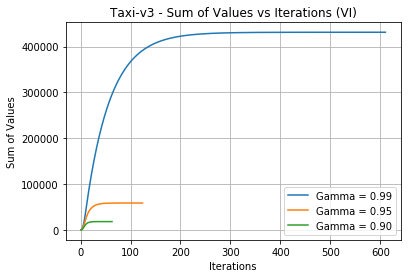

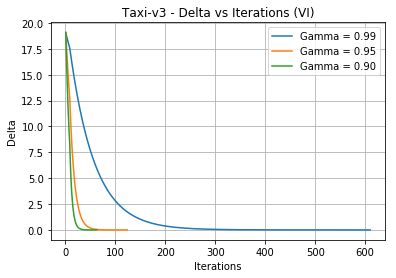

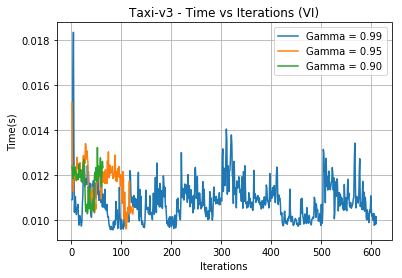

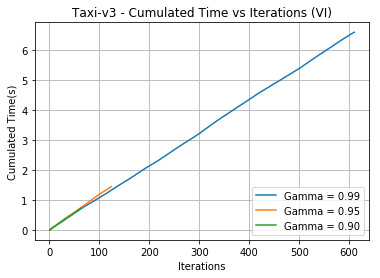

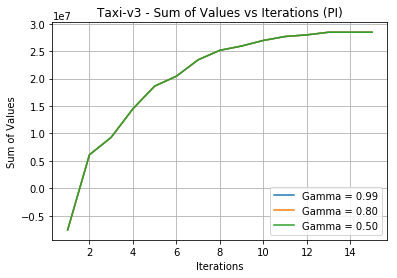

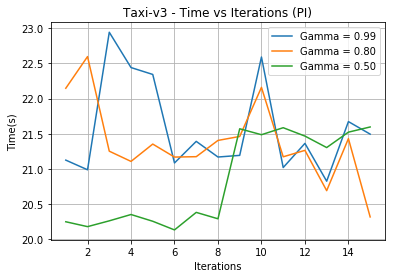

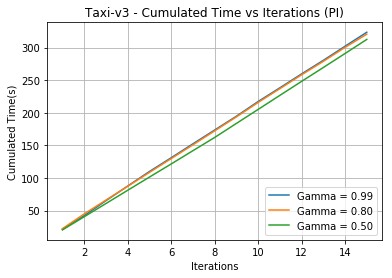

<Figure size 432x288 with 0 Axes>

In [43]:
# Switch plot backend
plt.switch_backend('Agg')
%matplotlib inline

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[6],label=label)
plt.title("Taxi-v3 - Sum of Values vs Iterations (VI)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Sum of Values')
plt.show()
plt.clf() 

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[3],label=label)
plt.title("Taxi-v3 - Delta vs Iterations (VI)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Delta')
plt.show()
plt.clf() 

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[4],label=label)
plt.title("Taxi-v3 - Time vs Iterations (VI)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Time(s)')
plt.show()
plt.clf() 

for gamma, results in vi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[5],label=label)
plt.title("Taxi-v3 - Cumulated Time vs Iterations (VI)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Cumulated Time(s)')
plt.show()
plt.clf() 
    
for gamma, results in pi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[5],label=label)
plt.title("Taxi-v3 - Sum of Values vs Iterations (PI)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Sum of Values')
plt.show()
plt.clf() 

for gamma, results in pi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[3],label=label)
plt.title("Taxi-v3 - Time vs Iterations (PI)")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Time(s)')
plt.show()
plt.clf() 

for gamma, results in pi_results.items():
    label = "Gamma = %.2f" %gamma
    plt.plot(range(1, results[2] + 1),results[4],label=label)
plt.title("Taxi-v3 - Cumulated Time vs Iterations (PI)")
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Cumulated Time(s)')
plt.show()
plt.clf() 

In [44]:
policy = vi_results[0.99][0]
policy2 = pi_results[0.99][0]
for x in range(len(policy)):
    if not (policy[x] == policy2[x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

policy = vi_results[0.99][0]
policy2 = pi_results[0.8][0]
for x in range(len(policy)):
    if not (policy[x] == policy2[x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

policy = vi_results[0.99][0]
policy2 = pi_results[0.5][0]
for x in range(len(policy)):
    if not (policy[x] == policy2[x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

policy = vi_results[0.99][0]
policy2 = vi_results[0.95][0]
for x in range(len(policy)):
    if not (policy[x] == policy2[x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

policy = vi_results[0.99][0]
policy2 = vi_results[0.90][0]
for x in range(len(policy)):
    if not (policy[x] == policy2[x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

Same Policy
Same Policy
Same Policy
Same Policy
Same Policy
